# IBM Quantum Experience Lab - Lab script

Please use this notebook as a template for the work that you will submit for assessment for this lab exercise.

Student Names: ENTER YOUR NAMES HERE

## Warm up exercise

In [6]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, Aer
from qiskit.tools.visualization import circuit_drawer
from qiskit import Aer
import matplotlib.pyplot as plt

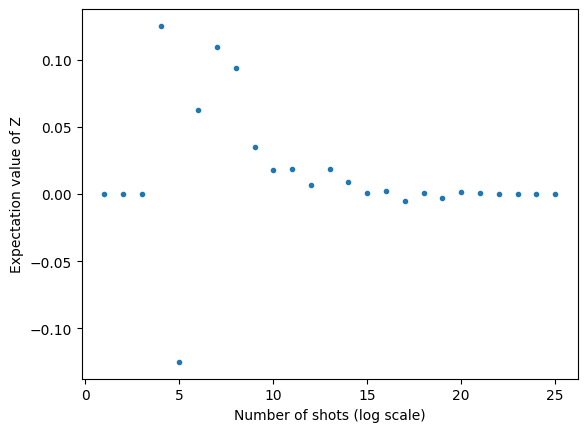

In [2]:
qr = QuantumRegister(1)
cr = ClassicalRegister(1)
circuit = QuantumCircuit(qr, cr)

circuit.h(qr[0])
circuit.measure(qr[0],cr[0])


backend = Aer.get_backend('qasm_simulator')

def get_expectation(result,circuit):
    return (result.get_counts(circuit)['0']-result.get_counts(circuit)['1'])/ (result.get_counts(circuit)['0'] + result.get_counts(circuit)['1'])
                                                                    
expectation_values = []
for n in range(1,26):
    job = execute(circuit, backend,shots=2**n)
    result = job.result()
    expectation_values.append(get_expectation(result,circuit))

plt.plot([n for n in range(1,26)], expectation_values, '.')
plt.xlabel('Number of shots (log scale)')
plt.ylabel('Expectation value of Z')
plt.show()

# Main Lab Exercise

In [71]:
import math
import numpy as np
import time
#Functions
def get_expectation_sim(circuit,backend,logshots):
    job = execute(circuit, backend,shots=2**logshots)
    result = job.result().get_counts(circuit)
    keys = list(result.keys())
    if set(keys) == set(['0','1']):
        return (result['0']-result['1'])/(result['0']+result['1']) , job.status()
    elif keys == ['0']:
        return 1.0, job.status()
    elif keys == ['1']:
        return -1.0, job.status()

def get_expectation(circuit,backend,logshots):
    job = execute(circuit, backend,shots=2**logshots)
    result = job.result().get_counts(circuit)
    runtime = result.time_taken
    keys = list(result.keys())
    if set(keys) == set(['0','1']):
        return (result['0']-result['1'])/(result['0']+result['1']) , runtime
    elif keys == ['0']:
        return 1.0, runtime
    elif keys == ['1']:
        return -1.0, runtime

def get_expectation_distribution(circuit, logshot, backend, draw=False):
    expectation_values = []
    for n in range(1,logshot):
        expectation_values.append(get_expectation(circuit,backend,n))
    if draw == True:
        plt.plot([n for n in range(1,logshot)], expectation_values, '.')
        plt.xlabel('Number of shots (log scale)')
        plt.ylabel('Expectation value of Z')
        plt.show()
        plt.close()
    return expectation_values

def initial_state(phi):
    state = math.cos(phi)*np.array([1,0]) + 1j*math.sin(phi)* np.array([0,1])
    return state


In [8]:
# Method 1 - apply HU^dagger(theta) and measure Z

#Build the cirquit
def method_1_circuit(theta, phi):
    qr = QuantumRegister(1)
    cr = ClassicalRegister(1)
    circuit = QuantumCircuit(qr, cr)
    circuit.initialize(initial_state(phi), qr[0])
    circuit.p(-theta, qr[0])
    circuit.h(qr[0])
    circuit.measure(qr[0],cr[0])
    return circuit

circuit_drawer(method_1_circuit(theta=math.pi/8, phi=math.pi/4))

┌──────────────────────────────┐┌─────────┐┌───┐┌─┐
  q0: ┤ Initialize(0.70711,0.70711j) ├┤ P(-π/8) ├┤ H ├┤M├
      └──────────────────────────────┘└─────────┘└───┘└╥┘
c0: 1/═════════════════════════════════════════════════╩═
                                                       0

In [9]:
# Method 2
# M(theta) = cos(theta)X + sin(theta)Y
# alpha = cos(theta) ; beta = sin(theta)

#Build the cirquits

#Measure X expectation value circuit
def method_2_X_circuit(theta,phi):
    qr = QuantumRegister(1)
    cr = ClassicalRegister(1)
    circuit = QuantumCircuit(qr, cr)
    circuit.initialize(initial_state(phi), qr[0])
    circuit.h(qr[0])
    circuit.measure(qr[0],cr[0])
    circuit_drawer(circuit)
    return circuit


circuit_drawer(method_2_X_circuit(theta=math.pi/4, phi=0))

┌─────────────────┐┌───┐┌─┐
  q1: ┤ Initialize(1,0) ├┤ H ├┤M├
      └─────────────────┘└───┘└╥┘
c1: 1/═════════════════════════╩═
                               0

In [10]:
#Measure Y expectation value circuit
def method_2_Y_circuit(theta,phi):
    qr = QuantumRegister(1)
    cr = ClassicalRegister(1)
    circuit = QuantumCircuit(qr, cr)
    circuit.initialize(initial_state(phi), qr[0])
    circuit.p(-math.pi/2,qr[0])
    circuit.h(qr[0])
    circuit.measure(qr[0],cr[0])
    circuit_drawer(circuit)
    return circuit

circuit_drawer(method_2_Y_circuit(theta=math.pi/4, phi=0))

┌─────────────────┐┌─────────┐┌───┐┌─┐
  q2: ┤ Initialize(1,0) ├┤ P(-π/2) ├┤ H ├┤M├
      └─────────────────┘└─────────┘└───┘└╥┘
c2: 1/════════════════════════════════════╩═
                                          0

In [75]:
def method1(theta,phi,backend,shots):
    circuit = method_1_circuit(theta, phi)
    return get_expectation(circuit,backend,shots)

def method2(theta,phi,backend,shots):
    '''
    Output: expectation value, job status of circuit X, job status of circuit Y
    '''
    circuit_X = method_2_X_circuit(theta, phi)
    expectation_X = get_expectation(circuit_X,backend,shots)[0]
    circuit_Y = method_2_Y_circuit(theta,phi)
    expectation_Y = get_expectation(circuit_Y,backend,shots)[0]
    expectation_M = math.cos(theta)*expectation_X + math.sin(theta)*expectation_Y
    return expectation_M, get_expectation(circuit_X,backend,shots)[1], get_expectation(circuit_Y,backend,shots)[1]

In [24]:
#Establish shots and backend simulator
shots = 20 #log scale
backend = Aer.get_backend('qasm_simulator')

In [25]:
#State 1
theta_1=math.pi/4
phi_1=0
print('Expectation value method 1:', method1(theta_1,phi_1,backend,shots,False)[0])
print('Expectation value method 2:', method2(theta_1,phi_1,backend,shots,False)[0])

Expectation value method 1: 0.0008182525634765625
JobStatus.DONE
Expectation value method 2: -0.0006905339660024879


In [ ]:
#State 2
theta_2=math.pi/8
phi_2=math.pi/4
print('Expectation value method 1:', method1(theta_2,phi_2,backend,shots,False)[0])
print('Expectation value method 2:', method2(theta_2,phi_2,backend,shots,False)[0])

Expectation value method 1: 0.38309478759765625
Expectation value method 2: 0.38159794158134697


# Analysis

In [79]:
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
mykey = 'd0db27e06149ec7280499124f8a6a11cf87d70d35c06147d3f70a8f9c0ae5a136f33ae887c14b0b44c10c1dc64e3249cc89aa7104fc3e01c940a3e1f1dead7fc'
IBMQ.save_account(mykey)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()

small_devices = provider.backends(filters=lambda x: x.configuration().n_qubits == 5
                                   and not x.configuration().simulator)
backend=least_busy(small_devices)

print(backend)

configrc.store_credentials:WARNING:2023-02-09 13:05:51,860: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2023-02-09 13:05:52,303: Credentials are already in use. The existing account in the session will be replaced.


ibmq_manila


In [80]:
#Generating data
method_1_state_1 = []
method_2_state_1 = []
method_1_state_2 = []
method_2_state_2 = []

runtime_method_1_state_1 = []
runtime_method_2_state_1 = []
runtime_method_1_state_2 = []
runtime_method_2_state_2 = []

In [81]:
import pandas as pd

n_simulations = 1
shots = 7 #log scale

for n in range(n_simulations):
    #start_method_1_state_1 = time.time()
    method_1_state_1.append(method1(theta_1,phi_1,backend,shots)[0])
    runtime_method_1_state_1.append(method1(theta_1,phi_1,backend,shots)[1])
    #end_method_1_state_1 = time.time()
    #runtime_method_1_state_1 += end_method_1_state_1 - start_method_1_state_1

m1_dict = {'Method 1 State 1':method_1_state_1}
pd.DataFrame(m1_dict).to_csv('Ibm_lima_method_1.csv')

for n in range(n_simulations):
    #start_method_2_state_1 = time.time()
    method_2_state_1.append(method2(theta_1,phi_1,backend,shots)[0])
    runtime_method_2_state_1.append(method2(theta_1,phi_1,backend,shots)[1])
    #end_method_2_state_1 = time.time()
    #runtime_method_2_state_1 += end_method_2_state_1 - start_method_2_state_1

m1_dict.update({'Method 2 State 1':method_1_state_2})
pd.DataFrame(m1_dict).to_csv('Ibm_lima_method_1.csv')


KeyboardInterrupt: 

In [ ]:
print(runtime_method_1_state_1)

In [ ]:
for n in range(n_simulations):
    start_method_1_state_2 = time.time()
    method_1_state_2.append(method1(theta_2,phi_2,backend,shots,False)[0])
    end_method_1_state_2 = time.time()
    runtime_method_1_state_2 += end_method_1_state_2 - start_method_1_state_2

m2_dict = {'Method 1 State 2':method_2_state_1}
pd.DataFrame(m1_dict).to_csv('Ibm_lima_method_2.csv')

for n in range(n_simulations):
    start_method_2_state_2 = time.time()
    method_2_state_2.append(method2(theta_2,phi_2,backend,shots,False)[0])
    end_method_2_state_2 = time.time()
    runtime_method_2_state_2 += end_method_2_state_2 - start_method_2_state_2

m2_dict.update({'Method 2 State 2':method_2_state_2})
pd.DataFrame(m2_dict).to_csv('Ibm_lima_method_2.csv')

In [68]:
s1_dict = {'Method 1' : method_1_state_1, 'Method 2' : method_2_state_1}
pd.DataFrame(s1_dict).to_csv('Ibm_lima_state_1.csv')

In [83]:
state_1_data_lima = pd.read_csv('Ibm_lima_state_1.csv')

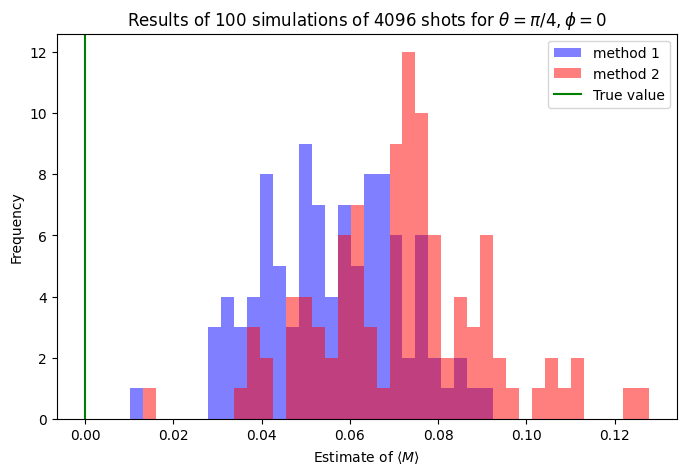

In [89]:
n_simulations = 100
shots = 2**12
M1_1 = state_1_data_lima['Method 1']
M2_1 = state_1_data_lima['Method 2']
fig1, ax1 = plt.subplots(figsize=(8,5))
bins=np.histogram(np.hstack((M1_1,M2_1)), bins=40)[1]
ax1.hist(M1_1, bins, color='b', alpha=0.5, label=f'method 1')
ax1.hist(M2_1, bins, color='r', alpha=0.5, label=f'method 2')
ax1.axvline(0.0, linestyle='-', c='g', label='True value')
ax1.set_xlabel(r'Estimate of $\langle M\rangle$')
ax1.set_ylabel('Frequency')
ax1.set_title(f'Results of {n_simulations} simulations of {shots} shots for '+r'$\theta=\pi/4, \phi=0$' +'on ibmq_lima')
ax1.legend()